# Gases

Gases, alongside particles, constitute the essential components of an aerosol system. In their natural state, gases are collections of molecules that move freely, not bound to one another. We introduce the `Gas` class, a composite that aggregates multiple `GasSpecies` objects, each representing type of gas or gases.

- **`Gas`**: Functions as a composite object capable of encompassing multiple `GasSpecies`, facilitating the management and operation of gas mixtures as coherent wholes.
Shared properties are `total_pressure` and `temperature`.
- **`GasBuilder`**: A builder class that simplifies the creation of `Gas` objects.

We'll continue with our organics and water example, combining the two into a single `Gas` object.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# From particula
from particula.next.gas import Gas, GasBuilder
from particula.next.vapor_pressure import vapor_pressure_factory
from particula.next.gas_species import GasSpeciesBuilder

## Build Gas Species

First we will build the, `GasSpecies` objects for the organics and water. Following the same procedure from previously in [`Gas Species`](./next_gas_species.ipynb).

In [6]:

# Define the coefficients for Butanol using the Antoine equation.
butanol_coefficients = {'a': 7.838, 'b': 1558.19, 'c': 196.881}
butanol_antione = vapor_pressure_factory(
    strategy='antoine', **butanol_coefficients)
styrene_coefficients = {'a': 6.924, 'b': 1420, 'c': 226}
styrene_antione = vapor_pressure_factory(
    strategy='antoine', **styrene_coefficients)

# Water uses a different model for vapor pressure calculation called the Buck equation.
water_buck = vapor_pressure_factory(
    strategy='water_buck')

# Create the GasSpecies using the GasSpeciesBuilder
# water species
water_species = GasSpeciesBuilder() \
    .name("Water") \
    .molar_mass(0.01801528) \
    .vapor_pressure_strategy(water_buck) \
    .condensable(True) \
    .concentration(0.017) \
    .build()

# organic species
organic_molar_mass = np.array([0.074121, 104.15e-3])
organic_vapor_pressure = [butanol_antione, styrene_antione]
organic_concentration = np.array([2e-6, 1e-9])
organic_names = np.array(["butanol", "styrene"])
organic_species = GasSpeciesBuilder() \
    .name(organic_names) \
    .molar_mass(organic_molar_mass) \
    .vapor_pressure_strategy(organic_vapor_pressure) \
    .condensable([True, True]) \
    .concentration(organic_concentration) \
    .build()

## GasBuilder

The `GasBuilder` class is a builder class that simplifies the creation of `Gas` objects. It provides a fluent interface for adding `GasSpecies` objects to the `Gas` object. We will use it to build the `Gas` object for the organics and water. The `GasBuilder` requries the following parameters:

- `total_pressure`: The total pressure of the gas mixture, in Pascals.
- `temperature`: The temperature of the gas mixture, in Kelvin.
- `species`: A list of `GasSpecies` objects, representing the gases in the mixture. This can be added one by one using the `species` method.

### Air

Air is assumed to be the non-specified component of the gas mixture, making up the remainder of the gas mixture. We do not explicitly add air to the gas mixture, but it is implicitly included in most calculations.

In [3]:
gas_mixture = GasBuilder() \
    .add_species(water_species) \
    .add_species(organic_species) \
    .temperature(300) \
    .total_pressure(101325) \
    .build()

print(gas_mixture)

Gas mixture at 300 K and 101325 Pa consisting of ['Water', "['butanol' 'styrene']"]


## Iterating Over Gas Species

Once the `Gas` object has been established, it enables us to iterate over each `GasSpecies` within the mixture. This functionality is particularly valuable for evaluating and adjusting properties dynamically, such as when changes in temperature and pressure occur due to environmental alterations.

### Practical Example: Altitude Impact

Consider a scenario where our gas mixture is transported from sea level to an altitude of 10 kilometers. Such a change in altitude significantly impacts both temperature and pressure, which in turn affects the behavior of each gas species in the mixture.

#### Geopotential Height Equation

The pressure and temperature changes with altitude can be approximated by using the geopotential height equation. Here's how you can calculate these changes:

1. **Pressure Change**: The pressure at a given altitude can be estimated by:
   
$$
   P = P_0 \left(1 - \frac{L \cdot h}{T_0}\right)^{\frac{g \cdot M}{R \cdot L}}
$$

   where:
   - $ P $ is the pressure at altitude $ h $,
   - $ P_0 $ is the reference pressure at sea level (101325 Pa),
   - $ L $ is the standard temperature lapse rate (approximately 0.0065 K/m),
   - $ h $ is the altitude in meters (10000 m for 10 km),
   - $ T_0 $ is the reference temperature at sea level (288.15 K),
   - $ g $ is the acceleration due to gravity (9.80665 m/s²),
   - $ M $ is the molar mass of Earth's air (0.0289644 kg/mol),
   - $ R $ is the universal gas constant (8.314 J/(mol·K)).

1. **Temperature Change**: The temperature decreases linearly with altitude at the lapse rate $ L $:
   
   $$
   T = T_0 - L h
   $$

   Using this formula, we can estimate the temperature at an altitude of 10 km:
   - $T$ = 288.15 K 
   - $L$ 0.0065 K/m
   - $h$ = 10000 m

### Application
By iterating through each `GasSpecies`, we can apply these formulas to adjust their properties based on the calculated pressure and temperature at 10 km altitude, aiding in simulations or real-world applications where altitude plays a crucial role in gas behavior.


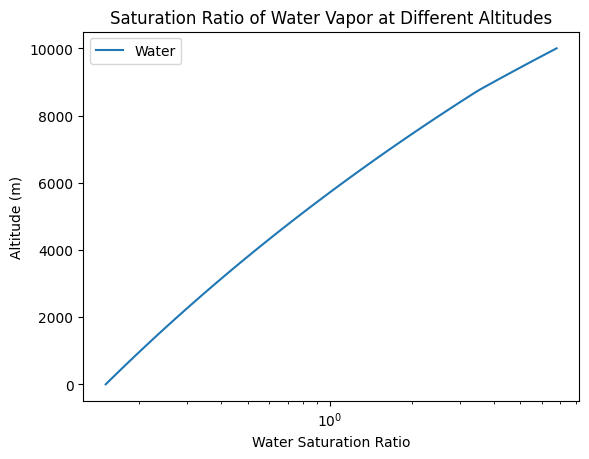

In [22]:
# Constants for calculations
sea_level_pressure = 101325  # Reference pressure at sea level (Pa)
sea_level_temperature = 330  # Reference temperature at sea level (K)
gravity = 9.80665  # Acceleration due to gravity (m/s^2)
molar_mass_air = 0.0289644  # Molar mass of Earth's air (kg/mol)
universal_gas_constant = 8.314    # Universal gas constant (J/(mol·K))
temperature_lapse_rate = 0.0065   # Standard temperature lapse rate (K/m)

# Generate an array of altitudes from sea level (0 meters) to 10 km (10000 meters), divided into 100 intervals
altitude_range = np.linspace(0, 10000, 100)

# Calculate the temperature at each altitude based on the linear temperature lapse rate
temperature_at_altitudes = sea_level_temperature - temperature_lapse_rate * altitude_range

# Calculate the pressure at each altitude using the barometric formula
pressure_at_altitudes = sea_level_pressure * (
    (1 - temperature_lapse_rate * altitude_range / sea_level_temperature)
    ** (gravity * molar_mass_air / (universal_gas_constant * temperature_lapse_rate)))


# Initialize a matrix to hold saturation ratios for each species at each
# altitude
saturation_ratio = np.zeros(len(altitude_range))

# Loop over each altitude's temperature and pressure
for index, (temperature, pressure) in enumerate(zip(temperature_at_altitudes, pressure_at_altitudes)):
    # Set the current temperature and pressure of the gas mixture
    gas_mixture.temperature = temperature
    gas_mixture.total_pressure = pressure

    # Loop over water
    saturation_ratio[index] = gas_mixture.species[0].get_saturation_ratio(gas_mixture.temperature)


# Plot the saturation ratio of water vapor at each altitude
fig, ax = plt.subplots()
ax.plot(saturation_ratio, altitude_range, label='Water')
ax.set_xscale('log')
ax.set_ylabel('Altitude (m)')
ax.set_xlabel('Water Saturation Ratio')
ax.set_title('Saturation Ratio of Water Vapor at Different Altitudes')
ax.legend()
plt.show()


# Summary

In this notebook, we introduced the `Gas` class, a composite object that aggregates multiple `GasSpecies` objects. We also discussed the `GasBuilder` class, which simplifies the creation of `Gas` objects. Finally, we explored how to iterate over `GasSpecies` objects within a `Gas` object, enabling dynamic property adjustments based on environmental changes, such as temperature and pressure variations.

We now need to combine this with particles to create an aerosol system.

# Help


In [23]:
help(GasBuilder)

Help on class GasBuilder in module particula.next.gas:

class GasBuilder(builtins.object)
 |  A builder class for creating Gas objects with a fluent interface.
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  add_species(self, species: particula.next.gas_species.GasSpecies)
 |      Add a gas species component to the gas mixture.
 |  
 |  build(self) -> particula.next.gas.Gas
 |      Build and return the Gas object.
 |  
 |  temperature(self, temperature: float)
 |      Set the temperature of the gas mixture, in Kelvin.
 |  
 |  total_pressure(self, total_pressure: float)
 |      Set the total pressure of the gas mixture, in Pascals.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables
 |  
 |  __weakref__
 |      list of weak references to the object



In [24]:
help(Gas)

Help on class Gas in module particula.next.gas:

class Gas(builtins.object)
 |  Gas(temperature: float, total_pressure: float, species: list[particula.next.gas_species.GasSpecies] = <factory>) -> None
 |  
 |  Represents a mixture of gas species, detailing properties such as
 |  temperature, total pressure, and the list of gas species in the mixture.
 |  
 |  Attributes:
 |  - temperature (float): The temperature of the gas mixture in Kelvin.
 |  - total_pressure (float): The total pressure of the gas mixture in Pascals.
 |  - species (List[GasSpecies]): A list of GasSpecies objects representing the
 |      species in the gas mixture.
 |  
 |  Methods:
 |  - add_species: Adds a gas species to the mixture.
 |  - remove_species: Removes a gas species from the mixture by index.
 |  
 |  Methods defined here:
 |  
 |  __eq__(self, other)
 |      Return self==value.
 |  
 |  __init__(self, temperature: float, total_pressure: float, species: list[particula.next.gas_species.GasSpecies] = <fac